In [2]:
import pandas as pd
import numpy as np
import random
from IPython.display import Image
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import networkx as nx
from networkx.algorithms import community
# Node2Vec
from sklearn.preprocessing import normalize
import random
import numpy
from matplotlib import pyplot

In [3]:
# Load the adjacency matrix into a numpy array.
ad_mat = np.loadtxt('../AD.txt', dtype=int)
for i in range(0,70):
        ad_mat[i][i] = 0
G_AD = nx.from_numpy_matrix(ad_mat)
print("Number Of Edges: ",len(G_AD.edges()))
print("Number Of Nodes: ",len(G_AD.nodes()))

Number Of Edges:  1364
Number Of Nodes:  70


In [4]:
emci_mat = np.loadtxt('../eMCI.txt', dtype=int)
#removing self loops
for i in range(0,70):
        emci_mat[i][i] = 0
G_eMCI = nx.from_numpy_matrix(emci_mat)
print("Number Of Edges: ",len(G_eMCI.edges()))
print("Number Of Nodes: ",len(G_eMCI.nodes()))

Number Of Edges:  1510
Number Of Nodes:  70


In [5]:
lmci_mat = np.loadtxt('../lMCI.txt', dtype=int)
#removing self loops
for i in range(0,70):
        lmci_mat[i][i] = 0
G_eMCI = nx.from_numpy_matrix(emci_mat)
G_lMCI = nx.from_numpy_matrix(lmci_mat)
print("Number Of Edges: ",len(G_lMCI.edges()))
print("Number Of Nodes: ",len(G_lMCI.nodes()))

Number Of Edges:  1380
Number Of Nodes:  70


In [6]:
normal_mat = np.loadtxt('../Normal.txt', dtype=int)
#removing self loops
for i in range(0,70):
        normal_mat[i][i] = 0
G_eMCI = nx.from_numpy_matrix(emci_mat)
G_Normal = nx.from_numpy_matrix(normal_mat)
print("Number Of Edges: ",len(G_Normal.edges()))
print("Number Of Nodes: ",len(G_Normal.nodes()))

Number Of Edges:  1490
Number Of Nodes:  70


In [7]:
#utility function to get removed edges
def removedEdges(first,second):
    removed = 0
    for edge in first:
        if edge not in second:
            removed+=1
    return removed
#utility function to get added adges
def addedEdges(first,second):
    added = 0
    for edge in second:
        if edge not in first:
            added+=1
    return added

In [8]:
add_Edges = []
remove_Edges = []
add_o = []
remove_o = []
def linkPredictWithAdamic(first,second):
    #loading matrix of first state
    normal_mat = np.loadtxt(first, dtype=int)
    #removing self loops
    for i in range(0,70):
            normal_mat[i][i] = 0
    #bilding graphs
    G_Normal = nx.from_numpy_matrix(normal_mat)
    print("Number Of Edges: ",len(G_Normal.edges()))
    print("Number Of Nodes: ",len(G_Normal.nodes()))
    #loading matrix of second state
    emci_mat = np.loadtxt(second, dtype=int)
    #removing self loops
    for i in range(0,70):
        emci_mat[i][i] = 0
    #building graph of second state
    G_eMCI = nx.from_numpy_matrix(emci_mat)
    #G_lMCI = nx.from_numpy_matrix(lmci_mat)
    print("Number Of Edges: ",len(G_eMCI.edges()))
    print("Number Of Nodes: ",len(G_eMCI.nodes()))
    print("Number Of Removed Edges: ",removedEdges(G_Normal.edges(),G_eMCI.edges()))
    print("Number of new Edges:",addedEdges(G_Normal.edges(),G_eMCI.edges()))
    edges = list(G_Normal.edges)
    node_list_1 = [item[0] for item in edges]
    node_list_2 = [item[1] for item in edges]
    # combine all nodes in a list
    node_list = node_list_1 + node_list_2

    # remove duplicate items from the list
    node_list = list(dict.fromkeys(node_list))
    #print(emci_mat)
    #print(type(emci_mat))
    ecmi_pred = emci_mat.copy()
    #prepare the positive score matrix
    pred_adamic = list(nx.adamic_adar_index(G_Normal))
    positive_score_mat = np.zeros((70,70))
    for i in node_list:
        for j in node_list:
            if i != j:
                positive_score_mat[i][j] = list(nx.adamic_adar_index(G_Normal,ebunch=[(i,j)]))[0][2]
    #positive_score_mat = normalize(positive_score_mat, axis=1, norm='l1')

    #preparing negative score matrix
    G_Normal_complement = nx.complement(G_Normal)
    pred_adamic = list(nx.adamic_adar_index(G_Normal_complement))
    negative_score_mat = np.zeros((70,70))
    for i in node_list:
        for j in node_list:
            if i != j:
                negative_score_mat[i][j] = list(nx.adamic_adar_index(G_Normal,ebunch=[(i,j)]))[0][2]
    #negative_score_mat = normalize(negative_score_mat, axis=1, norm='l1')
    #print(negative_score_mat)
    
    A = addedEdges(G_Normal.edges(),G_eMCI.edges())
    B = removedEdges(G_Normal.edges(),G_eMCI.edges())
    score=(A+B)*2
    print("yes..")
    done = []
    while(A>0 and B>0):
        maxIndex = 70
        TopRank=-1
        x=0
        y=0
        for i in range(maxIndex-1):
            for j in range(i+1,maxIndex):
                
                if(normal_mat[i][j]==0 and (i,j) not in done):
                    print(i,j)
                    tempRank = positive_score_mat[i][j]
                    if(tempRank>TopRank):
                        x=i
                        y=j
                        TopRank = tempRank
        #positive_score_mat[x][y] = -positive_score_mat[x][y]
        if(positive_score_mat[x][y]>negative_score_mat[x][y]):
            #adding link
            add_Edges.append((x,y,positive_score_mat[x][y],negative_score_mat[x][y]))
            ecmi_pred[x][y] = 1
            A-=1
            
            done.append((x,y))
        elif(ecmi_pred[x][y]==1):
            #removing edge
            remove_Edges.append((x,y,positive_score_mat[x][y],negative_score_mat[x][y]))
            ecmi_pred[x][y] = 0
            B-=1
            print(x,y)
            done.append((x,y))
        else:
            done.append((x,y))
    
        
    
    while(A>0):
        maxIndex = 70
        TopRank=-1
        x=0
        y=0
        for i in range(maxIndex-1):
            for j in range(i+1,maxIndex):
                if(normal_mat[i][j]==0 and (i,j) not in done):
                    tempRank = positive_score_mat[i][j]
                    if(tempRank>TopRank):
                        x=i
                        y=j
                        TopRank = tempRank
    
        ecmi_pred[x][y] = 1
        A-=1
        done.append((x,y))
        add_Edges.append((x,y,positive_score_mat[x][y],negative_score_mat[x][y]))
        
    while(B>0):
        maxIndex = 70
        TopRank=-1
        x=0
        y=0
        for i in range(maxIndex-1):
            for j in range(i+1,maxIndex):
                if(normal_mat[i][j]==1 and (i,j) not in done):
                    tempRank = negative_score_mat[i][j]
                    if(tempRank>TopRank):
                        x=i
                        y=j
                        TopRank = tempRank
    
        ecmi_pred[x][y] = 0
        remove_Edges.append((x,y,positive_score_mat[x][y],negative_score_mat[x][y]))
        
        B-=1
        done.append((x,y))
    o_diff = np.subtract(emci_mat,normal_mat)
    for i in range(70):
        for j in range(i,70):
            if o_diff[i][j]!=0:
                if o_diff[i][j]==1:
                    add_o.append((i,j,positive_score_mat[i][j],negative_score_mat[i][j]))
                
                if o_diff[i][j]==-1:
                    remove_o.append((i,j,positive_score_mat[i][j],negative_score_mat[i][j]))
    diff = np.subtract(emci_mat,ecmi_pred)    
    dist = 0
    for i in range(70):
        for j in range(i,70):
            if diff[i][j]!=0:
                dist+=1
    print("score: ",score)
    matching  = (score-dist)/score
    print("Matching Score:: ",matching)
    print(len(done))

## Hist for adamic adar score adding and removed edges.

### Normal to emci

In [34]:
add_Edges = []
remove_Edges = []
add_o = []
remove_o = []
linkPredictWithAdamic('../Normal.txt','../eMCI.txt')
added_df = pd.DataFrame()
added_df['first'] = [item[0] for item in add_Edges]  
added_df['second'] = [item[1] for item in add_Edges] 
added_df['pos'] = [item[2] for item in add_Edges] 
added_df['neg'] = [item[3] for item in add_Edges]  

remove_df = pd.DataFrame()
remove_df['first'] = [item[0] for item in remove_Edges]  
remove_df['second'] = [item[1] for item in remove_Edges] 
remove_df['pos'] = [item[2] for item in remove_Edges]
remove_df['neg'] = [item[3] for item in remove_Edges]  

added_df_o = pd.DataFrame()
added_df_o['first'] = [item[0] for item in add_o]  
added_df_o['second'] = [item[1] for item in add_o] 
added_df_o['pos'] = [item[2] for item in add_o] 
added_df_o['neg'] = [item[3] for item in add_o]  

remove_df_o = pd.DataFrame()
remove_df_o['first'] = [item[0] for item in remove_o]  
remove_df_o['second'] = [item[1] for item in remove_o] 
remove_df_o['pos'] = [item[2] for item in remove_o] 
remove_df_o['neg'] = [item[3] for item in remove_o]  

Number Of Edges:  1490
Number Of Nodes:  70
Number Of Edges:  1510
Number Of Nodes:  70
Number Of Removed Edges:  79
Number of new Edges: 99
score:  356
Matching Score::  0.5196629213483146
473


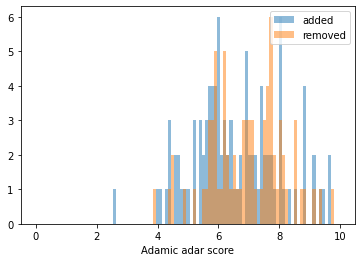

In [35]:
x = added_df_o['pos']
y = remove_df_o['pos']

bins = numpy.linspace(0, 10, 100)

pyplot.hist(x, bins, alpha=0.5, label='added')
pyplot.hist(y, bins, alpha=0.5, label='removed')
pyplot.legend(loc='upper right')
pyplot.xlabel('Adamic adar score')
pyplot.show()

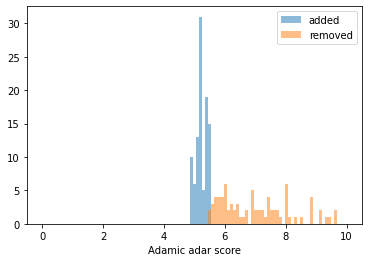

In [36]:
x = added_df['pos']
y = remove_df['pos']

bins = numpy.linspace(0, 10, 100)

pyplot.hist(x, bins, alpha=0.5, label='added')
pyplot.hist(y, bins, alpha=0.5, label='removed')
pyplot.xlabel('Adamic adar score')
pyplot.legend(loc='upper right')
pyplot.show()

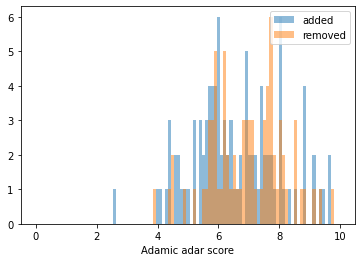

In [37]:
x = added_df_o['neg']
y = remove_df_o['neg']

bins = numpy.linspace(0, 10, 100)

pyplot.hist(x, bins, alpha=0.5, label='added')
pyplot.hist(y, bins, alpha=0.5, label='removed')
pyplot.legend(loc='upper right')
pyplot.xlabel('Adamic adar score')

pyplot.show()

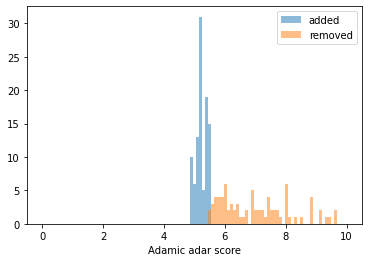

In [38]:
x = added_df['neg']
y = remove_df['neg']
bins = numpy.linspace(0, 10,100)
pyplot.hist(x, bins, alpha=0.5, label='added')
pyplot.hist(y, bins, alpha=0.5, label='removed')
pyplot.xlabel('Adamic adar score')
pyplot.legend(loc='upper right')
pyplot.show()

### EMCI to LMCI

In [9]:
add_Edges = []
remove_Edges = []
add_o = []
remove_o = []
linkPredictWithAdamic('../lMCI.txt','../AD.txt')
added_df = pd.DataFrame()
added_df['first'] = [item[0] for item in add_Edges]  
added_df['second'] = [item[1] for item in add_Edges] 
added_df['pos'] = [item[2] for item in add_Edges] 
added_df['neg'] = [item[3] for item in add_Edges]  

remove_df = pd.DataFrame()
remove_df['first'] = [item[0] for item in remove_Edges]  
remove_df['second'] = [item[1] for item in remove_Edges] 
remove_df['pos'] = [item[2] for item in remove_Edges]
remove_df['neg'] = [item[3] for item in remove_Edges]  

added_df_o = pd.DataFrame()
added_df_o['first'] = [item[0] for item in add_o]  
added_df_o['second'] = [item[1] for item in add_o] 
added_df_o['pos'] = [item[2] for item in add_o] 
added_df_o['neg'] = [item[3] for item in add_o]  

remove_df_o = pd.DataFrame()
remove_df_o['first'] = [item[0] for item in remove_o]  
remove_df_o['second'] = [item[1] for item in remove_o] 
remove_df_o['pos'] = [item[2] for item in remove_o] 
remove_df_o['neg'] = [item[3] for item in remove_o]  

Number Of Edges:  1380
Number Of Nodes:  70
Number Of Edges:  1364
Number Of Nodes:  70
Number Of Removed Edges:  90
Number of new Edges: 74
yes..
0 3
0 18
0 25
0 31
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 45
0 46
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 60
0 61
0 62
0 64
0 65
0 66
0 67
0 68
0 69
1 3
1 4
1 5
1 15
1 32
1 33
1 35
1 38
1 39
1 40
1 41
1 42
1 43
1 45
1 47
1 49
1 50
1 55
1 56
1 64
1 67
1 68
2 3
2 15
2 32
2 35
2 38
2 39
2 40
2 41
2 42
2 43
2 44
2 45
2 46
2 47
2 48
2 49
2 50
2 52
2 53
2 54
2 55
2 56
2 59
2 63
2 64
2 65
2 66
2 67
2 68
2 69
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
3 31
3 32
3 33
3 34
3 35
3 36
3 37
3 38
3 39
3 40
3 41
3 42
3 43
3 44
3 45
3 46
3 47
3 48
3 49
3 50
3 51
3 52
3 53
3 54
3 55
3 56
3 57
3 58
3 59
3 60
3 61
3 62
3 63
3 64
3 65
3 66
3 67
3 68
3 69
4 5
4 11
4 18
4 19
4 25
4 31
4 32
4 35
4 36
4 37
4 38
4 40
4 41
4 43
4 46
4 48
4 49
4 50
4 52
4 53


KeyboardInterrupt: 

In [ ]:
x = added_df_o['pos']
y = remove_df_o['pos']

bins = numpy.linspace(0, 10, 100)

pyplot.hist(x, bins, alpha=0.5, label='added')
pyplot.hist(y, bins, alpha=0.5, label='removed')
pyplot.legend(loc='upper right')
pyplot.xlabel('Adamic adar score')
pyplot.show()

In [ ]:
x = added_df['pos']
y = remove_df['pos']

bins = numpy.linspace(0, 10, 100)

pyplot.hist(x, bins, alpha=0.5, label='added')
pyplot.hist(y, bins, alpha=0.5, label='removed')
pyplot.xlabel('Adamic adar score')
pyplot.legend(loc='upper right')
pyplot.show()

In [ ]:
x = added_df_o['neg']
y = remove_df_o['neg']

bins = numpy.linspace(0, 10, 100)

pyplot.hist(x, bins, alpha=0.5, label='added')
pyplot.hist(y, bins, alpha=0.5, label='removed')
pyplot.legend(loc='upper right')
pyplot.xlabel('Adamic adar score')

pyplot.show()

In [ ]:
x = added_df['neg']
y = remove_df['neg']
bins = numpy.linspace(0, 10,100)
pyplot.hist(x, bins, alpha=0.5, label='added')
pyplot.hist(y, bins, alpha=0.5, label='removed')
pyplot.xlabel('Adamic adar score')
pyplot.legend(loc='upper right')
pyplot.show()

### LMCI to AD

### Normal to AD